In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## 1. Q-learning in the wild

이전 챕터에서 만든 Q-learning class를 그대로 가져와쓴다. 주석이 없으니 헷갈리면 이전 notebook을 참고하자!

In [2]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-07-11 17:58:54,832] Making new env: Taxi-v2


In [3]:
import random,math

import numpy as np
from collections import defaultdict

class QLearningAgent():
    def __init__(self,alpha,epsilon,discount,getLegalActions):
        self.getLegalActions= getLegalActions
        self._qValues = defaultdict(lambda:defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
  
    def getQValue(self, state, action):
        return self._qValues[state][action]
  
    def setQValue(self,state,action,value):
        self._qValues[state][action] = value
  
    def getValue(self, state):
        possibleActions = self.getLegalActions(state)

        if len(possibleActions) == 0:
            return 0.0

        return np.max(np.array([self.getQValue(state, action)
                               for action in possibleActions]))
      
    def getPolicy(self, state):
        possibleActions = self.getLegalActions(state)
    
        if len(possibleActions) == 0:
            return None
        
        best_action_idx = np.argmax([self.getQValue(state, action)
                           for action in possibleActions])
        best_action = possibleActions[best_action_idx]        
        return best_action
  
    def getAction(self, state):
        possibleActions = self.getLegalActions(state)
        action = None
        
        if len(possibleActions) == 0:
            return None
    
        epsilon = self.epsilon
    
        e_greedy_prob = np.random.rand()
        
        if e_greedy_prob < epsilon:
            return np.random.choice(possibleActions)
        
        return self.getPolicy(state)
  
    def update(self, state, action, nextState, reward):
        gamma = self.discount
        learning_rate = self.alpha
    
        reference_qvalue = reward + gamma*self.getValue(nextState)
        
        updated_qvalue = (1-learning_rate) * self.getQValue(state,action) + learning_rate * reference_qvalue

        self.setQValue(state,action,updated_qvalue)

In [4]:
agent = QLearningAgent(alpha=0.5,epsilon=0.2,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [5]:
def play_and_train(env,agent,t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        next_s,r,done,_ = env.step(a)
        
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward

mean reward -4.9


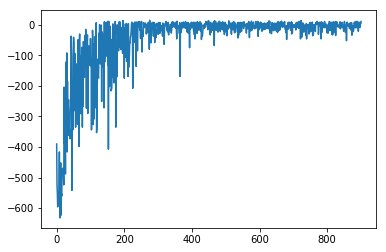

In [6]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        

## 2. SARSA (2 pts)

### TODO (Sarsa의 원리) 수식 추가

* Q-learning: 다음 state의 최적 Q-value로 update
* SARSA: update를 할 때, 실제 next_action으로 update

그래서 SARSA를 쓰면 noisy한 policy에 대해서 value를 가지며, 더 최적화가 가능하다.

물론 해당 예제에서는 epsilon-greedy 방식으로 random action을 해도 value값이 크게 바뀌지 않는다.

따라서 다른 예제에서 결과를 확인해보는 것이 좋을 것이다.

## 구현

sarsa에서 달라지는 부분은 update하는 로직뿐이다. QLearningAgent를 상속받아 작성해보자.

In [7]:
class SarsaAgent(QLearningAgent):
    def updateSarsa(self, state, action, nextState, nextAction, reward):
        gamma = self.discount
        learning_rate = self.alpha

        # maxValue를 받지 않고, nextAction에 대해서 받는다.
        reference_qvalue = reward + gamma*self.getQValue(nextState, nextAction)
        
        updated_qvalue = (1-learning_rate) * self.getQValue(state, action) \
                        + learning_rate * reference_qvalue
        self.setQValue(state, action, updated_qvalue)


In [8]:
agent = SarsaAgent(alpha=0.25, epsilon=0.25, discount=0.99,
                   getLegalActions = lambda s: range(n_actions))
# SARSA는 더 작은 learning rate를 필요로 한다.

In [9]:
def play_and_train_sarsa(env,agent,t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        
        next_s,r,done,_ = env.step(a)
        
        # agent가 다음 action을 결정한다!!
        next_a = agent.getAction(next_s)
        
        agent.updateSarsa(s, a, next_s, next_a, r)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward

mean reward -21.84


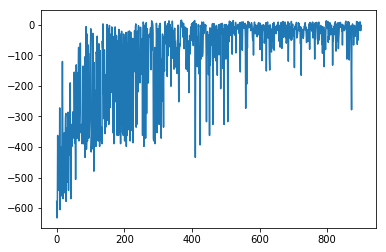

In [10]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train_sarsa(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        


## 3. Expected value SARSA (2 pts)

요거는 아직 제대로 안돈다... Sampling을 하라는 것 같은데... 나중에 다시보자

In [39]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-07-11 18:12:43,034] Making new env: Taxi-v2


In [46]:
class EVSarsaAgent(QLearningAgent):
    def getValue(self, state):
        possibleActions = self.getLegalActions(state)

        if len(possibleActions) == 0:
            return 0.0

        epsilon = self.epsilon
        -
        QValues = np.array([self.getQValue(state, action) 
                            for action in possibleActions])
        norm_QValues = QValues/np.sum(QValues+0.000001)*(1-epsilon)
        value = np.sum(np.dot(norm_QValues, QValues.T))


        epsilons = np.array([epsilon]*len(possibleActions))
        value += np.sum(np.dot(epsilons, QValues.T))
        
        
        return value

agent = EVSarsaAgent(alpha=0.5,
                     epsilon=0.25,
                     discount=0.99,
                     getLegalActions = lambda s: range(n_actions))

In [45]:
QValues = np.array([1, 2, 3])

norm_QValues = QValues/np.sum(QValues+0.000001)
print(norm_QValues)
value = np.sum(np.dot(norm_QValues, QValues.T))
print(value)

[ 0.16666658  0.33333317  0.49999975]
2.33333216667


### Train EV-SARSA

Note that it uses __the same update parameters as__ qlearning so you can use the ```play_and_train``` function from q-learning.

Please try both constant epsilon = 0.25 and decreasing epsilon.

mean reward -678.79


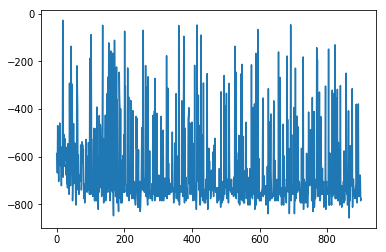

In [43]:

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()